<a href="https://colab.research.google.com/github/hwangho-kim/Utility-OAC/blob/main/Daily_FDC_Monitoring_(PCA_%2B_Mahalanobis).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


========================= Phase 1: 기준 모델 생성 =========================
'golden_data.csv' 이름으로 샘플 CSV 파일을 생성합니다...
샘플 파일 생성 완료.
골든 데이터셋에서 99개의 정상 Wafer를 식별했습니다.
차원 축소 완료: 800개 특징 -> 85개 주성분

정규화 기준값(99th percentile Mahalanobis Distance in PCA space): 9.6781
최종 인덱스용 스케일링 팩터: 0.9678

기준 모델 생성 및 저장 완료.

========================= Phase 2: 일일 모니터링 시작 =========================
저장된 기준 모델(PCA + Mahalanobis)을 성공적으로 불러왔습니다.

--- 2025-07-31 데이터 모니터링 ---
'daily_data_day_1.csv' 이름으로 샘플 CSV 파일을 생성합니다...
샘플 파일 생성 완료.
2025-07-31의 정규화된 Daily Index: 9.2132

--- 2025-08-01 데이터 모니터링 ---
'daily_data_day_2.csv' 이름으로 샘플 CSV 파일을 생성합니다...
샘플 파일 생성 완료.
2025-08-01의 정규화된 Daily Index: 9.6112

--- 2025-08-02 데이터 모니터링 ---
'daily_data_day_3.csv' 이름으로 샘플 CSV 파일을 생성합니다...
샘플 파일 생성 완료.
2025-08-02의 정규화된 Daily Index: 10.5372

--- 2025-08-03 데이터 모니터링 ---
'daily_data_day_4.csv' 이름으로 샘플 CSV 파일을 생성합니다...
샘플 파일 생성 완료.
2025-08-03의 정규화된 Daily Index: 11.8648

--- 2025-08-04 데이터 모니터링 ---
'daily_data_day_5.csv' 이름으로 샘플 CSV 파일을 생성합니다

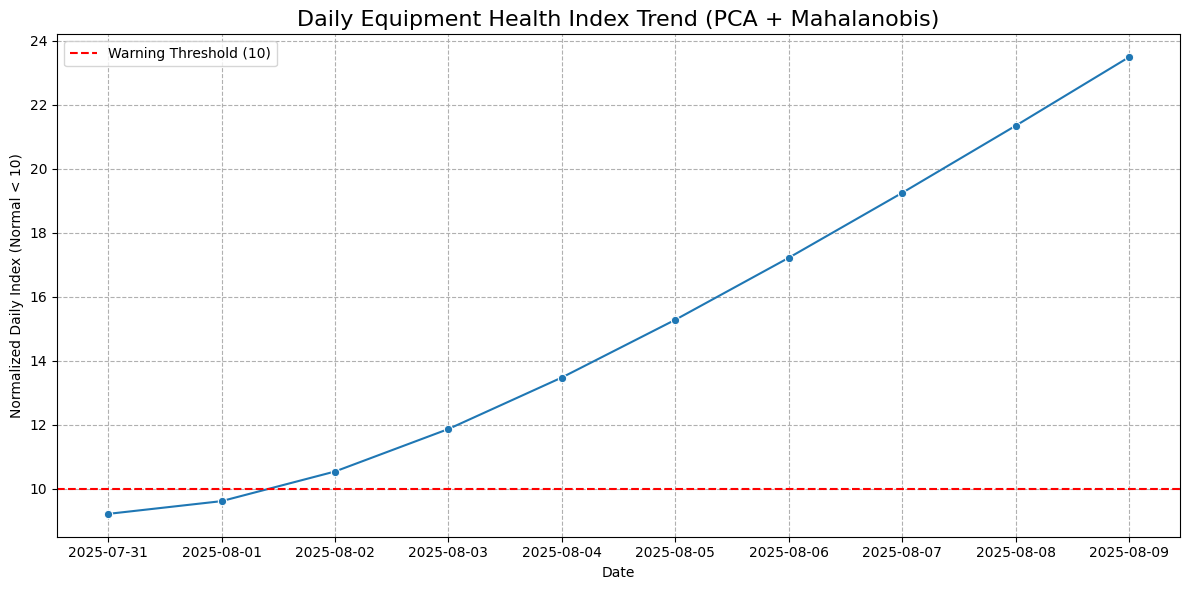

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
import joblib
from datetime import date, timedelta
from scipy.spatial.distance import mahalanobis

# --- 그래프 한글 폰트 설정 ---
try:
    import koreanize_matplotlib
except ImportError:
    pass

# --- 데이터 생성 및 특징 추출 함수들 (이전과 동일) ---
def create_long_format_csv(filepath, num_wafers, anomaly_info=None):
    print(f"'{filepath}' 이름으로 샘플 CSV 파일을 생성합니다...")
    num_steps, num_sensors, time_points = 10, 10, 10
    np.random.seed(42)
    records = []
    for wafer_id in range(1, num_wafers + 1):
        for step_id in range(1, num_steps + 1):
            record_base = {'wafer_id': wafer_id, 'step_id': step_id}
            for i in range(num_sensors):
                sensor_name = f'Sensor_{chr(65+i)}'
                record_base[sensor_name] = np.random.randn(time_points) * (i * 0.1 + 0.5) + (i * 5 + step_id)
            if anomaly_info:
                if (anomaly_info.get('wafer_id') is None or wafer_id >= anomaly_info['wafer_id']) and \
                   (anomaly_info.get('step_id') is None or step_id == anomaly_info['step_id']):
                    record_base['Sensor_C'] += anomaly_info.get('c_drift', 0)
                    record_base['Sensor_G'] *= anomaly_info.get('g_noise', 1)
            for t_idx in range(time_points):
                row = {**record_base, 'time': t_idx}
                for i in range(num_sensors):
                    sensor_name = f'Sensor_{chr(65+i)}'
                    row[sensor_name] = record_base[sensor_name][t_idx]
                records.append(row)
    df = pd.DataFrame(records)
    df.to_csv(filepath, index=False)
    print("샘플 파일 생성 완료.")
    return df

def find_columns(df):
    id_candidates = {'wafer': ['wafer_id'], 'step': ['step_id'], 'time': ['time']}
    detected_cols = {}
    remaining_cols = list(df.columns)
    for id_type, candidates in id_candidates.items():
        found = False
        for col in remaining_cols:
            if col.lower() in candidates:
                detected_cols[id_type] = col; remaining_cols.remove(col); found = True; break
        if not found: detected_cols[id_type] = None
    sensor_cols = [col for col in remaining_cols if pd.api.types.is_numeric_dtype(df[col])]
    return detected_cols['wafer'], detected_cols['step'], sensor_cols

def extract_and_pivot_features(df, wafer_id_col, step_id_col, sensor_cols):
    def rms(x): return np.sqrt(np.mean(x**2))
    agg_funcs = ['mean', 'std', 'max', 'min', 'median', 'skew', pd.Series.kurt, rms]
    features = df.groupby([wafer_id_col, step_id_col])[sensor_cols].agg(agg_funcs).reset_index()
    new_cols = [wafer_id_col, step_id_col]
    for col_level0, col_level1 in features.columns[2:]:
        func_name = col_level1 if isinstance(col_level1, str) else col_level1.__name__
        new_cols.append(f"{col_level0}_{func_name}")
    features.columns = new_cols
    feature_pivot = features.pivot(index=wafer_id_col, columns=step_id_col)
    feature_pivot.columns = [f"S{int(col[1])}_{col[0]}" for col in feature_pivot.columns.values]
    feature_pivot.fillna(0, inplace=True)
    return feature_pivot.reset_index()

# ======================================================================================
# Phase 1: 기준 모델 생성 (최초 1회 실행)
# ======================================================================================
def train_and_save_reference_model(golden_data_path='golden_data.csv'):
    print("\n" + "="*25 + " Phase 1: 기준 모델 생성 " + "="*25)

    # 1. 골든 데이터셋 생성 및 특징 추출
    create_long_format_csv(golden_data_path, num_wafers=100)
    df_long = pd.read_csv(golden_data_path)
    wafer_id_col, step_id_col, sensor_cols = find_columns(df_long)
    df_wide = extract_and_pivot_features(df_long, wafer_id_col, step_id_col, sensor_cols)
    feature_cols = [col for col in df_wide.columns if col != wafer_id_col]

    # 2. DBSCAN으로 정상 군집 찾기
    scaler_dbscan = StandardScaler()
    X_scaled = scaler_dbscan.fit_transform(df_wide[feature_cols])

    try: from kneed import KneeLocator
    except ImportError: print("오류: 'kneed' 라이브러리가 필요합니다. 'pip install kneed'를 실행해주세요."); return

    nearest_neighbors = NearestNeighbors(n_neighbors=5).fit(X_scaled)
    distances, _ = nearest_neighbors.kneighbors(X_scaled)
    sorted_distances = np.sort(distances[:, 4])
    kneedle = KneeLocator(x=range(1, len(sorted_distances)+1), y=sorted_distances, S=1.0, curve="convex", direction="increasing")
    optimal_eps = kneedle.elbow_y or np.median(sorted_distances)

    dbscan = DBSCAN(eps=optimal_eps, min_samples=5)
    clusters = dbscan.fit_predict(X_scaled)
    df_wide['dbscan_cluster'] = clusters

    main_cluster_label = pd.Series(clusters).value_counts().idxmax()
    golden_df = df_wide[df_wide['dbscan_cluster'] == main_cluster_label].copy()
    print(f"골든 데이터셋에서 {len(golden_df)}개의 정상 Wafer를 식별했습니다.")

    # --- [수정됨] PCA + 마할라노비스 거리 기반 모델 생성 ---
    # 3. 스케일러와 PCA 모델 학습
    scaler_final = StandardScaler()
    golden_features_scaled = scaler_final.fit_transform(golden_df[feature_cols])

    pca_model = PCA(n_components=0.95) # 95%의 분산을 설명하는 주성분으로 차원 축소
    golden_features_pca = pca_model.fit_transform(golden_features_scaled)
    print(f"차원 축소 완료: {len(feature_cols)}개 특징 -> {pca_model.n_components_}개 주성분")

    # 4. 축소된 차원에서 마할라노비스 거리 계산을 위한 모델 생성
    mean_vector_pca = np.mean(golden_features_pca, axis=0)
    covariance_matrix_pca = np.cov(golden_features_pca, rowvar=False)
    inv_covariance_matrix_pca = np.linalg.inv(covariance_matrix_pca)

    # 5. 정규화를 위한 기준값(Baseline) 계산
    golden_distances = [mahalanobis(row, mean_vector_pca, inv_covariance_matrix_pca) for row in golden_features_pca]
    health_index_baseline = np.percentile(golden_distances, 99)
    scaling_factor = health_index_baseline / 10.0 + 1e-9
    print(f"\n정규화 기준값(99th percentile Mahalanobis Distance in PCA space): {health_index_baseline:.4f}")
    print(f"최종 인덱스용 스케일링 팩터: {scaling_factor:.4f}")

    # 6. 학습된 모델과 기준값 파일로 저장
    joblib.dump(scaler_final, 'scaler_final.joblib')
    joblib.dump(pca_model, 'pca_model.joblib')
    joblib.dump(mean_vector_pca, 'mean_vector_pca.joblib')
    joblib.dump(inv_covariance_matrix_pca, 'inv_cov_matrix_pca.joblib')
    joblib.dump(feature_cols, 'feature_cols.joblib')
    joblib.dump(scaling_factor, 'scaling_factor_final.joblib')

    print("\n기준 모델 생성 및 저장 완료.")
    print("="*70)

# ======================================================================================
# Phase 2: 일일 모니터링 (매일 반복 실행)
# ======================================================================================
def run_daily_monitoring(days_to_monitor=10):
    print("\n" + "="*25 + " Phase 2: 일일 모니터링 시작 " + "="*25)

    # 1. 저장된 기준 모델 불러오기
    try:
        scaler_final = joblib.load('scaler_final.joblib')
        pca_model = joblib.load('pca_model.joblib')
        mean_vector_pca = joblib.load('mean_vector_pca.joblib')
        inv_covariance_matrix_pca = joblib.load('inv_cov_matrix_pca.joblib')
        feature_cols = joblib.load('feature_cols.joblib')
        scaling_factor = joblib.load('scaling_factor_final.joblib')
        print("저장된 기준 모델(PCA + Mahalanobis)을 성공적으로 불러왔습니다.")
    except FileNotFoundError:
        print("오류: 기준 모델 파일(.joblib)을 찾을 수 없습니다. Phase 1을 먼저 실행해주세요.")
        return

    daily_log = []
    start_date = date.today()

    for day in range(days_to_monitor):
        current_date = start_date + timedelta(days=day)
        print(f"\n--- {current_date} 데이터 모니터링 ---")

        # 2. 일일 데이터 생성 및 특징 추출
        daily_data_path = f'daily_data_day_{day+1}.csv'
        degradation_info = {'c_drift': day * 0.1, 'g_noise': 1 + day * 0.02}
        create_long_format_csv(daily_data_path, num_wafers=20, anomaly_info=degradation_info)
        df_long_daily = pd.read_csv(daily_data_path)

        wafer_id_col, step_id_col, sensor_cols = find_columns(df_long_daily)
        df_wide_daily = extract_and_pivot_features(df_long_daily, wafer_id_col, step_id_col, sensor_cols)
        df_wide_daily = df_wide_daily[df_wide_daily.columns.intersection([wafer_id_col] + feature_cols)]

        # 3. 불러온 기준 모델로 Health Index 계산
        daily_features_scaled = scaler_final.transform(df_wide_daily[feature_cols])
        daily_features_pca = pca_model.transform(daily_features_scaled)

        # [수정됨] PCA 공간에서 마할라노비스 거리 계산
        raw_health_indexes = [mahalanobis(row, mean_vector_pca, inv_covariance_matrix_pca) for row in daily_features_pca]

        # 4. 정규화된 Daily Index 계산 및 기록
        raw_daily_index = np.mean(raw_health_indexes)
        normalized_daily_index = raw_daily_index / scaling_factor

        print(f"{current_date}의 정규화된 Daily Index: {normalized_daily_index:.4f}")
        daily_log.append({'date': current_date, 'daily_index': normalized_daily_index})

    # 5. Daily Index 로그 저장 및 시각화
    log_df = pd.DataFrame(daily_log)
    log_df.to_csv('daily_health_log.csv', index=False)
    print("\n일일 모니터링 로그 저장 완료: daily_health_log.csv")

    plt.figure(figsize=(12, 6))
    sns.lineplot(x='date', y='daily_index', data=log_df, marker='o')
    plt.axhline(y=10, color='r', linestyle='--', label='Warning Threshold (10)')
    plt.title('Daily Equipment Health Index Trend (PCA + Mahalanobis)', fontsize=16)
    plt.xlabel('Date')
    plt.ylabel('Normalized Daily Index (Normal < 10)')
    plt.legend()
    plt.grid(True, linestyle='--')
    plt.tight_layout()
    plt.show()


if __name__ == '__main__':
    # Phase 1: 기준이 되는 모델을 생성하고 파일로 저장합니다.
    train_and_save_reference_model()

    # Phase 2: 저장된 모델을 불러와 매일 모니터링을 수행합니다.
    run_daily_monitoring(days_to_monitor=10)

In [1]:
!pip install kneed